# **Detección de anomalías en los patrones de comportamiento de los clientes no regulados en la filial Electro Dunas del Grupo Energía Bogotá**

Este Notebook, hace parte del trabajo de grado de la maestría en inteligencia analítica de datos de la Universidad de los Andes en él se realizan la verificación de supuestos, búsqueda de los mejores hiperparametros y evalución de desempeño en la clasificación por parte de los modelos.

Realizado por: Miller Puentes, Grace González, Camilo, Robayo, Joan Chacón.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Para colocar el enlace al Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Establece la ruta de la carpeta donde se almacenan los archivos CSV.
folder_path = '/content/drive/My Drive/MIAD_Trabajo de grado/Entrega 3/Datos/Datos Crudos/'

# Lista todos los archivos CSV en la carpeta especificada.
# Utilizamos list comprehension para filtrar solo los archivos que terminan en '.csv'.
files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Crea un DataFrame vacío para almacenar los datos combinados de todos los archivos CSV.
all_data = pd.DataFrame()

# Itera sobre cada archivo en la lista de archivos CSV.
for file in files:
    # Construye la ruta completa al archivo para poder cargarlo.
    file_path = os.path.join(folder_path, file)

    # Lee el archivo CSV y lo carga en un DataFrame.
    data = pd.read_csv(file_path)

    # Extrae el número de cliente del nombre del archivo. Esto asume que el número de cliente
    # está incrustado en el nombre del archivo y sigue el formato 'DATOSCLIENTE<numero>.csv'.
    cliente_id = int(file.replace('DATOSCLIENTE', '').replace('.csv', ''))

    # Agrega una nueva columna al DataFrame con el ID del cliente extraído del nombre del archivo.
    data['Cliente_ID'] = cliente_id

    # Concatena el DataFrame actual con el DataFrame 'all_data' que acumula los datos de todos los archivos.
    all_data = pd.concat([all_data, data], ignore_index=True)

# Carga datos adicionales de un archivo Excel que contiene información sobre el sector económico de cada cliente.
file_path = '/content/drive/My Drive/MIAD_Trabajo de grado/Entrega 3/Datos/Datos Crudos/sector_economico_clientes.xlsx'
sector_economico_clientes = pd.read_excel(file_path)

# Extrae el ID del cliente del campo 'Cliente:' que asumimos contiene el nombre del cliente y su ID.
# El método 'extract' utiliza una expresión regular para obtener solo los dígitos del campo.
sector_economico_clientes['Cliente_ID'] = (
    sector_economico_clientes['Cliente:']
    .str.extract('(\d+)')  # Extrae el número del nombre del cliente
    .astype(int)           # Convierte el resultado en entero
)

# Combina los datos de 'all_data' con 'sector_economico_clientes' utilizando 'Cliente_ID' como clave.
# Esto permite integrar la información del sector económico para cada entrada de datos de consumo.
data_merged = pd.merge(all_data, sector_economico_clientes, on='Cliente_ID', how='left')

# Muestra las primeras filas del DataFrame combinado para verificar la correcta combinación de datos.
data_merged.head()


,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Cliente:,Sector Económico:
0,2021-01-01 00:00:00,0.446463,0.110000,1909.104939,1931.272013,11,Cliente 11,Cultivo de otros frutos y nueces de árboles y ...
1,2021-01-01 01:00:00,0.266168,0.006182,1920.553856,1941.566712,11,Cliente 11,Cultivo de otros frutos y nueces de árboles y ...
2,2021-01-01 02:00:00,0.363697,0.047294,1951.934446,1935.518214,11,Cliente 11,Cultivo de otros frutos y nueces de árboles y ...
3,2021-01-01 03:00:00,0.117586,0.028356,1929.028793,1890.880093,11,Cliente 11,Cultivo de otros frutos y nueces de árboles y ...
4,2021-01-01 04:00:00,0.168862,0.110000,1894.441042,1908.817223,11,Cliente 11,Cultivo de otros frutos y nueces de árboles y ...


In [ ]:

# Filtra las filas donde la energía activa es mayor o igual a cero.
# Esto elimina cualquier dato erróneo o no aplicable donde la energía activa podría haber sido registrada como un valor negativo.
data_filtered_neg = data_merged[data_merged['Active_energy'] >= 0]

# Imprime las dimensiones del DataFrame original y el DataFrame después de filtrar.
# Esto es útil para verificar cuántas filas fueron eliminadas durante el proceso de filtrado.
print("Original data shape:", data_merged.shape)
print("Filtered data shape (Active_energy >= 0):", data_filtered_neg.shape)

# Ordena los datos filtrados primero por 'Cliente_ID' y luego por 'Fecha'.
# Esto organiza los datos de manera que sea más fácil analizarlos secuencialmente por cliente y cronológicamente.
data_filtered_neg_sorted = data_filtered_neg.sort_values(by=['Cliente_ID', 'Fecha'])

# Convierte la columna 'Fecha' a formato datetime si no lo está.
# Esto asegura que las operaciones subsiguientes en las fechas sean manejadas correctamente.
data_filtered_neg_sorted['Fecha'] = pd.to_datetime(data_filtered_neg_sorted['Fecha'])

# Establece las fechas de inicio y fin para el rango deseado.
fecha_inicio = '2018-01-01'
fecha_fin = '2024-11-30'

# Filtra el DataFrame para incluir solo las filas donde la 'Fecha' cae dentro del rango establecido.
# Utiliza el método between() para simplificar este proceso y asegurar que todas las fechas están correctamente incluidas.
data_filtered_neg_sorted = data_filtered_neg_sorted[
    data_filtered_neg_sorted['Fecha'].between(fecha_inicio, fecha_fin)
]

# Imprime las dimensiones del DataFrame original y del DataFrame después de todos los filtros para mostrar el efecto acumulativo.
# Esto ayuda a comprender el impacto de los filtros aplicados en términos de reducción de la cantidad de datos.
print("Final data shape after all filters:", data_filtered_neg_sorted.shape)

Original data shape: (463425, 8)
Filtered data shape (Active_energy >= 0): (462920, 8)
Final data shape after all filters: (462920, 8)


# Anomalías Energía Reactiva (ER)/ Energía Activa (EA)

Este tipo de Anomalías es importante porque dependiendo de la Energía Reactiva consumida con respecto a la Energía Activa en un mismo més se puede generar sobre cargos para el cliente por incumplimiento de la clusula 10.4:

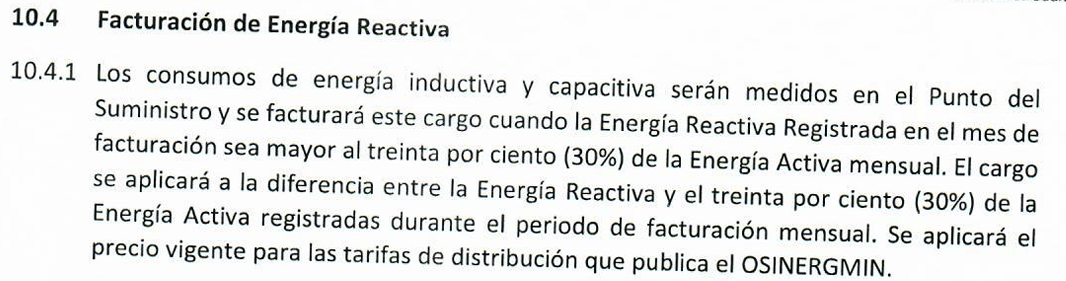

In [ ]:
def anomalias_ER_EA(data_filtered_neg, num_cliente):
   # """
   # Genera un DataFrame resumido para un cliente específico que muestra el consumo total
   # de energía activa y reactiva por mes y determina si hay anomalías basadas en la relación entre ellas.
   # """
    # Filtrar el DataFrame por el número de cliente.
    df = data_filtered_neg[data_filtered_neg['Cliente_ID'] == num_cliente]
    df = df[['Fecha', 'Active_energy', 'Reactive_energy']]

    # Convertir la columna 'Fecha' a tipo datetime y establecer como índice del DataFrame.
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df.set_index('Fecha', inplace=True)

    # Sumar el consumo de energía activa y reactiva por mes.
    df_resumen = df.resample('M').sum()

    # Agregar el ID del cliente y calcular el porcentaje de energía reactiva sobre energía activa.
    df_resumen['Cliente_ID'] = num_cliente
    df_resumen['Reactive_to_Active_ratio'] = (df_resumen['Reactive_energy'] / df_resumen['Active_energy']) * 100

    # Crear y establecer la columna 'Anomalía' según el criterio especificado.
    df_resumen['Anomalía'] = 0
    df_resumen.loc[df_resumen['Reactive_to_Active_ratio'] > 30, 'Anomalía'] = 1
    df_resumen.reset_index(inplace=True)

    return df_resumen

def evaluar_todos_los_clientes(data_filtered_neg):
   # """
   # Evalúa todos los clientes en el DataFrame dado para calcular y resumir el consumo de energía
   # y las anomalías basadas en la relación entre la energía reactiva y activa.
   # """
    resultados = []
    clientes_unicos = data_filtered_neg['Cliente_ID'].unique()

    # Iterar sobre cada cliente único y aplicar la función de gráfica y resumen.
    for num_cliente in clientes_unicos:
        resultado_cliente = anomalias_ER_EA(data_filtered_neg, num_cliente)
        resultados.append(resultado_cliente)

    # Concatenar todos los resultados individuales en un único DataFrame.
    df_resultados = pd.concat(resultados, ignore_index=True)

    return df_resultados


# Usar la función en el DataFrame 'data_filtered_neg_sorted' para evaluar todos los clientes.

df_anomalias_ER_EA = evaluar_todos_los_clientes(data_filtered_neg_sorted)
df_anomalias_ER_EA

,Fecha,Active_energy,Reactive_energy,Cliente_ID,Reactive_to_Active_ratio,Anomalía
0,2021-01-31,1179.028493,415.713658,1,35.259000,1
1,2021-02-28,1490.128945,231.737781,1,15.551525,0
2,2021-03-31,1728.240344,978.845693,1,56.638285,1
3,2021-04-30,2228.447578,1304.500199,1,58.538519,1
4,2021-05-31,2190.919624,1269.936238,1,57.963616,1
...,...,...,...,...,...,...
651,2021-12-31,557.623290,162.509190,30,29.143186,0
652,2022-01-31,555.454032,164.041544,30,29.532875,0
653,2022-02-28,502.660360,149.013247,30,29.644917,0
654,2022-03-31,556.726413,160.706109,30,28.866263,0


In [ ]:
# Ruta donde se guardará el archivo CSV.
ruta_csv = '/content/drive/My Drive/MIAD_Trabajo de grado/Entrega 3/Datos/df_anomalias_ER_EA.csv'

# Guardar el DataFrame 'df_anomalias_ER_EA' como un archivo CSV en la ubicación especificada.
# Se establece 'index=False' para no incluir el índice del DataFrame en el archivo, manteniendo solo los datos.
df_anomalias_ER_EA.to_csv(ruta_csv, index=False)

# Nota: Este archivo CSV se utilizará posteriormente como parte de los datos de entrada para una consulta en Power BI.
# Al ser incluido en Power BI, este archivo servirá como base para una de las tablas en el tablero de control (dashboard),
# permitiendo realizar análisis visuales y detallados sobre las anomalías en el consumo de energía reactiva y activa.

# Modelo Isolation Forest

In [ ]:
# Diccionario predefinido con los mejores hiperparámetros para cada cliente.
best_params_dict = {
    1: {'contamination': 0.02, 'n_estimators': 50},
    2: {'contamination': 0.02, 'n_estimators': 50},
    3: {'contamination': 0.02, 'n_estimators': 50},
    4: {'contamination': 0.02, 'n_estimators': 50},
    5: {'contamination': 0.02, 'n_estimators': 50},
    6: {'contamination': 0.02, 'n_estimators': 150},
    7: {'contamination': 0.02, 'n_estimators': 200},
    8: {'contamination': 0.02, 'n_estimators': 50},
    9: {'contamination': 0.02, 'n_estimators': 50},
    10: {'contamination': 0.01, 'n_estimators': 100},
    11: {'contamination': 0.03, 'n_estimators': 50},
    12: {'contamination': 0.03, 'n_estimators': 50},
    13: {'contamination': 0.03, 'n_estimators': 150},
    14: {'contamination': 0.03, 'n_estimators': 50},
    15: {'contamination': 0.03, 'n_estimators': 50},
    16: {'contamination': 0.03, 'n_estimators': 200},
    17: {'contamination': 0.03, 'n_estimators': 50},
    18: {'contamination': 0.03, 'n_estimators': 50},
    19: {'contamination': 0.03, 'n_estimators': 50},
    20: {'contamination': 0.03, 'n_estimators': 150},
    21: {'contamination': 0.03, 'n_estimators': 50},
    22: {'contamination': 0.03, 'n_estimators': 100},
    23: {'contamination': 0.03, 'n_estimators': 50},
    24: {'contamination': 0.03, 'n_estimators': 50},
    25: {'contamination': 0.03, 'n_estimators': 50},
    26: {'contamination': 0.03, 'n_estimators': 100},
    27: {'contamination': 0.03, 'n_estimators': 50},
    28: {'contamination': 0.03, 'n_estimators': 150},
    29: {'contamination': 0.03, 'n_estimators': 150},
    30: {'contamination': 0.03, 'n_estimators': 150}
}

def apply_isolation_forest(client_id, data):
    """
    Aplica el modelo Isolation Forest a los datos de energía activa de un cliente específico,
    utilizando parámetros predefinidos para detectar anomalías.

    Args:
    client_id (int): ID del cliente.
    data (DataFrame): DataFrame que contiene los datos de los clientes.

    Returns:
    DataFrame: Datos del cliente con columnas adicionales de anomalías y puntuaciones de anomalías.
    """
    client_data = data[data['Cliente_ID'] == client_id].copy()
    client_data['Active_energy'] = client_data['Active_energy'].astype(np.float64)
    client_data['Fecha'] = pd.to_datetime(client_data['Fecha'])
    client_data['Mes'] = client_data['Fecha'].dt.month
    client_data['Dia_de_Semana'] = client_data['Fecha'].dt.dayofweek
    client_data['Franja_Horaria'] = client_data['Fecha'].dt.hour.apply(
        lambda h: '12am-6am' if 0 <= h < 6 else '6am-12pm' if 6 <= h < 12 else '12pm-6pm' if 12 <= h < 18 else '6pm-12am'
    )

    params = best_params_dict.get(client_id)
    if params:
        model = IsolationForest(n_estimators=params['n_estimators'], contamination=params['contamination'], random_state=123)
        anomalies = model.fit_predict(client_data[['Active_energy']])
        client_data['Anomaly_IF'] = (anomalies == -1).astype(int)
        client_data['Anomaly_Score_IF'] = model.decision_function(client_data[['Active_energy']])
        return client_data
    else:
        print(f"No se encontraron hiperparámetros para el cliente {client_id}")
        return None

def detect_anomalies_criticidad(client_data):
    """
    Evalúa la criticidad de las anomalías detectadas en los datos de energía activa del cliente.

    Args:
    client_data (DataFrame): DataFrame que contiene datos y resultados de anomalías del cliente.

    Returns:
    DataFrame: DataFrame actualizado con una columna de criticidad para cada anomalía detectada.
    """
    # Asignar "No anomalía" a todas las filas donde Anomaly_IF es 0
    client_data['criticidad'] = 'No anomalía'

    if 'Anomaly_IF' in client_data.columns and (client_data['Anomaly_IF'] == 1).any():
        # Calcular la mediana y desviación estándar para toda la columna Active_energy
        median = client_data['Active_energy'].median()
        std_dev = client_data['Active_energy'].std()

        # Calcular el Z-Score para toda la columna Active_energy
        client_data['Z_Score'] = (client_data['Active_energy'] - median) / std_dev

        # Asignar criticidad basada en el Z-Score para las filas donde Anomaly_IF es 1
        client_data.loc[client_data['Anomaly_IF'] == 1, 'criticidad'] = pd.cut(client_data.loc[client_data['Anomaly_IF'] == 1, 'Z_Score'],
                                                                              bins=[-np.inf, -2.5, -1.25, 1.25, 2.25, 2.5, np.inf],
                                                                              labels=['crítica', 'moderada', 'No anomalía', 'leve', 'moderada', 'crítica'],
                                                                              right=False,
                                                                              ordered=False)
    else:
        print("No se encontraron anomalías en los datos del cliente.")
    return client_data

# Ejemplo de uso del código con data_filtered_neg_sorted como DataFrame de entrada.
unique_clients = data_filtered_neg_sorted['Cliente_ID'].unique()
all_results = []

for client_id in unique_clients:
    client_results = apply_isolation_forest(client_id, data_filtered_neg_sorted)
    if client_results is not None:
        client_results = detect_anomalies_criticidad(client_results)
        all_results.append(client_results)

# Concatenar todos los resultados en un DataFrame final.
df_anomalias_IF = pd.concat(all_results)
df_anomalias_IF = df_anomalias_IF[['Fecha', 'Cliente_ID', 'Sector Económico:', 'Mes', 'Dia_de_Semana', 'Franja_Horaria', 'Active_energy', 'Anomaly_IF', 'Anomaly_Score_IF', 'criticidad']]
df_anomalias_IF.head(3)


,Fecha,Cliente_ID,Sector Económico:,Mes,Dia_de_Semana,Franja_Horaria,Active_energy,Anomaly_IF,Anomaly_Score_IF,criticidad
14000,2021-01-01 00:00:00,1,Elaboración de cacao y chocolate y de producto...,1,4,12am-6am,0.357841,0,0.094817,No anomalía
14001,2021-01-01 01:00:00,1,Elaboración de cacao y chocolate y de producto...,1,4,12am-6am,0.372264,0,0.095188,No anomalía
14002,2021-01-01 02:00:00,1,Elaboración de cacao y chocolate y de producto...,1,4,12am-6am,1.044687,0,0.204764,No anomalía


In [ ]:
# Ruta donde se guardará el archivo CSV que contiene los resultados del análisis de anomalías.
ruta_csv = '/content/drive/My Drive/MIAD_Trabajo de grado/Entrega 3/Datos/df_anomalias_IF.csv'

# Guardar el DataFrame 'df_anomalias_IF' como un archivo CSV en la ubicación especificada.
# Se establece 'index=False' para no incluir el índice del DataFrame en el archivo, manteniendo solo los datos.
df_anomalias_IF.to_csv(ruta_csv, index=False)

# Nota: Este archivo CSV está destinado a ser utilizado en Power BI como parte de las tablas de un tablero.
# Al cargar este CSV en Power BI, permitirá realizar visualizaciones interactivas y análisis profundos
# sobre las anomalías detectadas en los consumos de energía de los clientes. Este paso facilita la integración
# de los resultados analíticos en una herramienta de BI para compartir insights y mejorar la toma de decisiones.


### Gráficas

In [ ]:
def graficar_energia_por_cliente_y_anomalia(dataframe):
    df = dataframe.copy()
    # Identificar los clientes únicos
    clientes = df['Cliente_ID'].unique()

    # Identificar las columnas de anomalías
    columnas_anomalias = ['Anomaly_IF']

    # Definir colores para cada nivel de criticidad
    colores_criticidad = {
        'crítica': 'red',
        'moderada': 'orange',
        'leve': 'yellow',
        'normal': 'green'
    }

    for cliente in clientes:
        for anomalia in columnas_anomalias:
            # Filtrar datos por cliente
            data_cliente = df[df['Cliente_ID'] == cliente]
            data_cliente['Fecha'] = pd.to_datetime(data_cliente['Fecha'])

            # Crear el gráfico
            plt.figure(figsize=(10, 6))

            # Graficar la energía activa
            plt.plot(data_cliente['Fecha'], data_cliente['Active_energy'], color='tab:blue', label='Energía Activa')

            # Filtrar y graficar las anomalías con colores según la criticidad
            if anomalia == 'Anomaly_IF':
                for criticidad, color in colores_criticidad.items():
                    anomalias_cliente = data_cliente[(data_cliente[anomalia] > 0) & (data_cliente['criticidad'] == criticidad)]
                    if not anomalias_cliente.empty:
                        plt.scatter(anomalias_cliente['Fecha'], anomalias_cliente['Active_energy'], color=color, s=25, label=f'Nivel {criticidad}')
                plt.title(f'Anomalías en la Energía Activa para el Cliente {cliente}')
            else:
                anomalias_cliente = data_cliente[data_cliente[anomalia] > 0]
                if not anomalias_cliente.empty:
                    plt.scatter(anomalias_cliente['Fecha'], anomalias_cliente['Active_energy'], color='#800080', s=25, label='Anomalía')
                    plt.title(f'Anomalías en la Energía Activa para el Cliente {cliente} - Anomalía: {anomalia}')

            plt.xlabel('Fecha')
            plt.ylabel('Energía Activa')
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.legend()
            plt.show()
            print("")


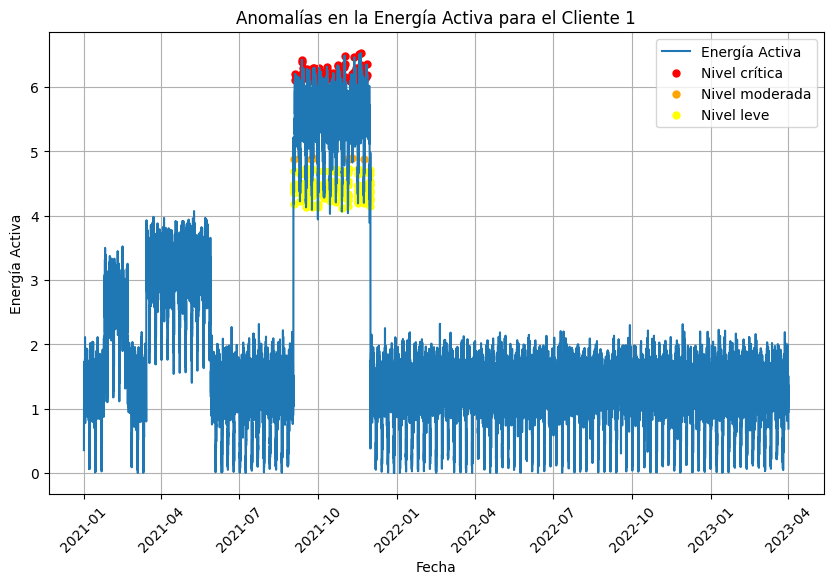

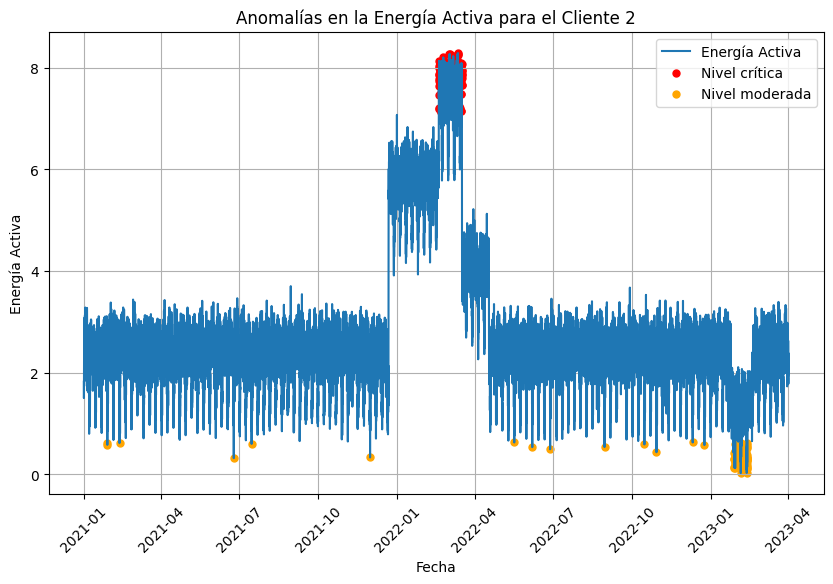

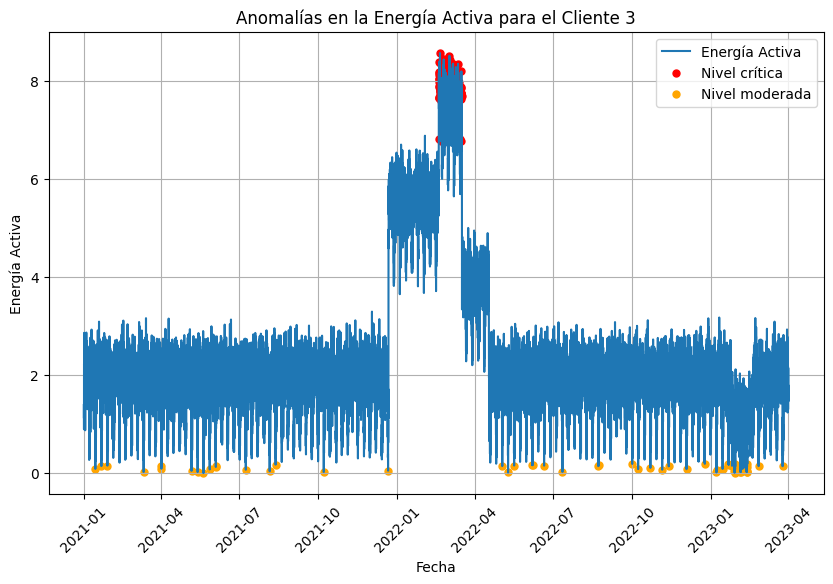

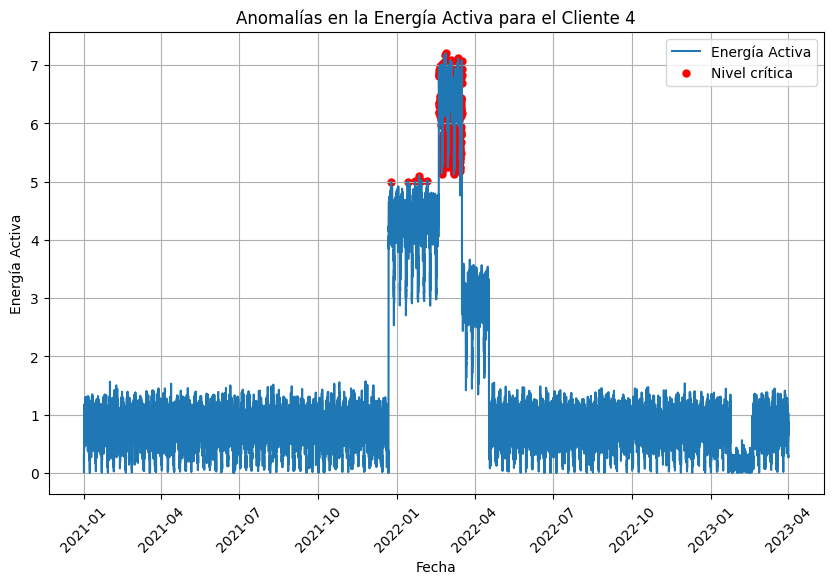

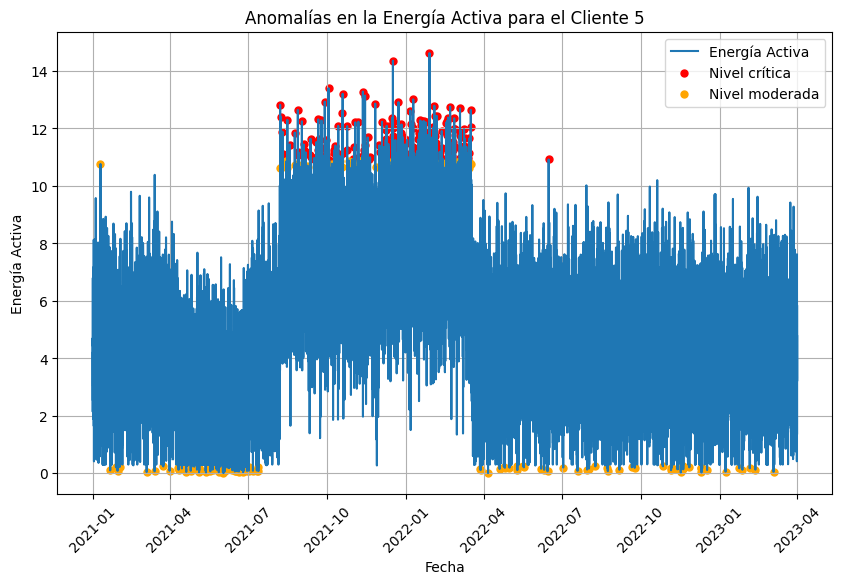

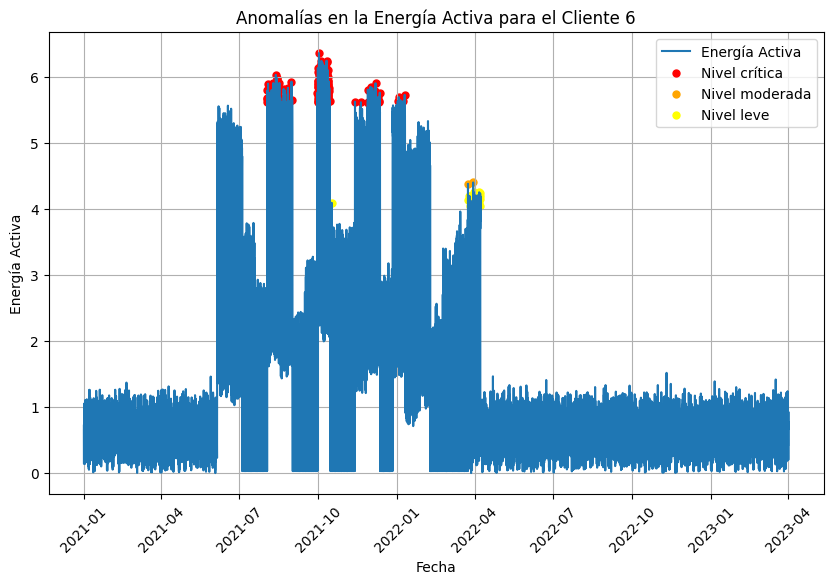

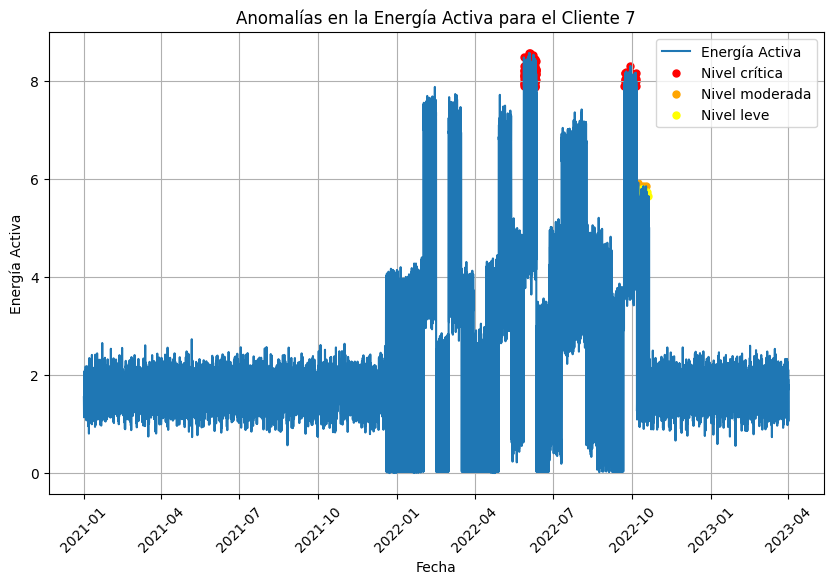

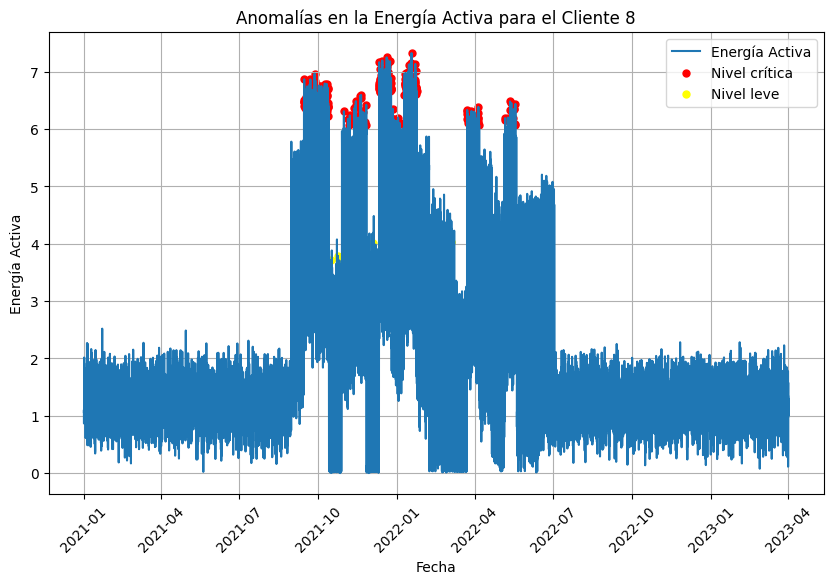

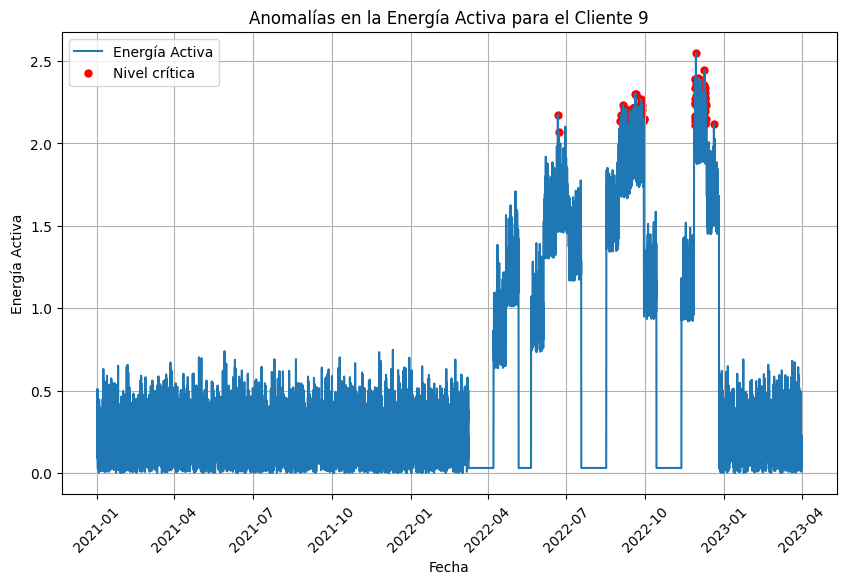

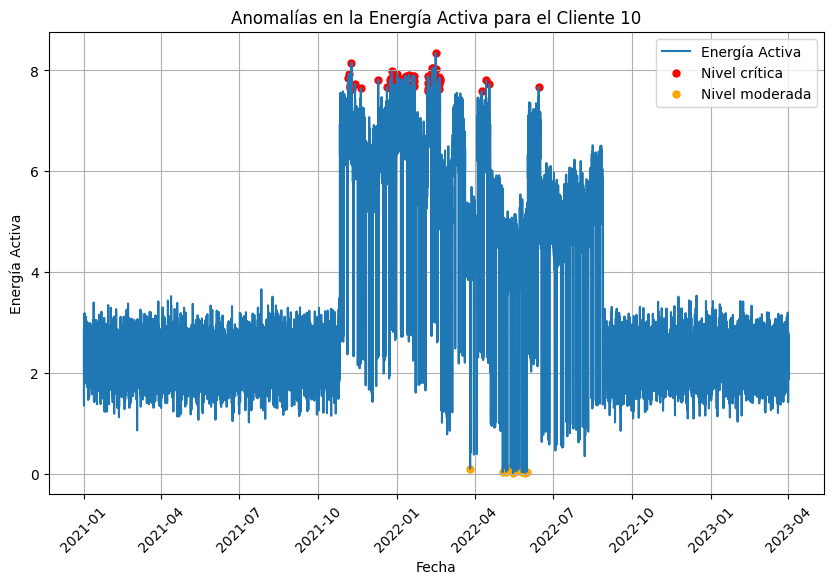

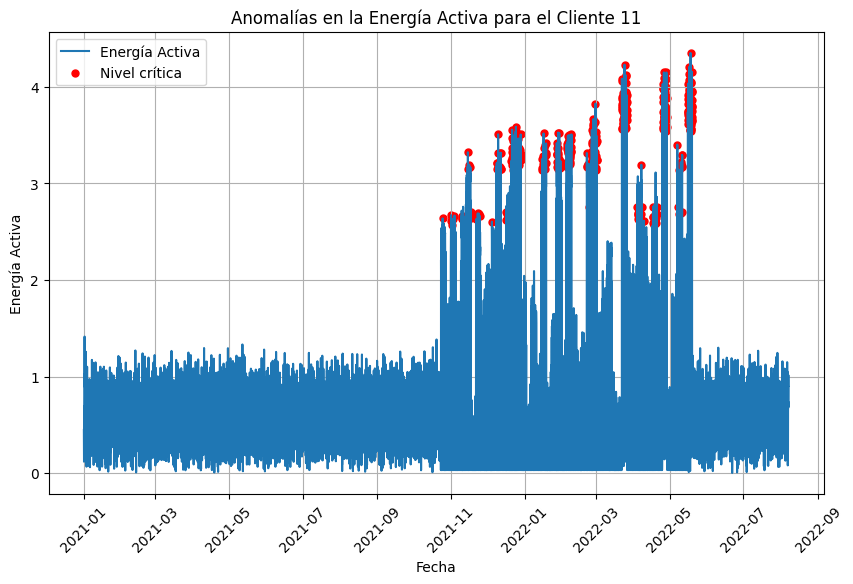

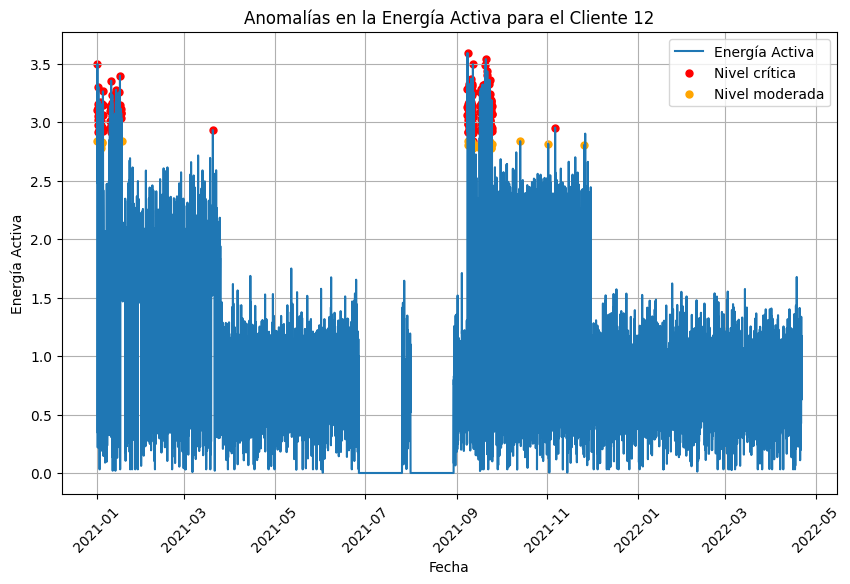

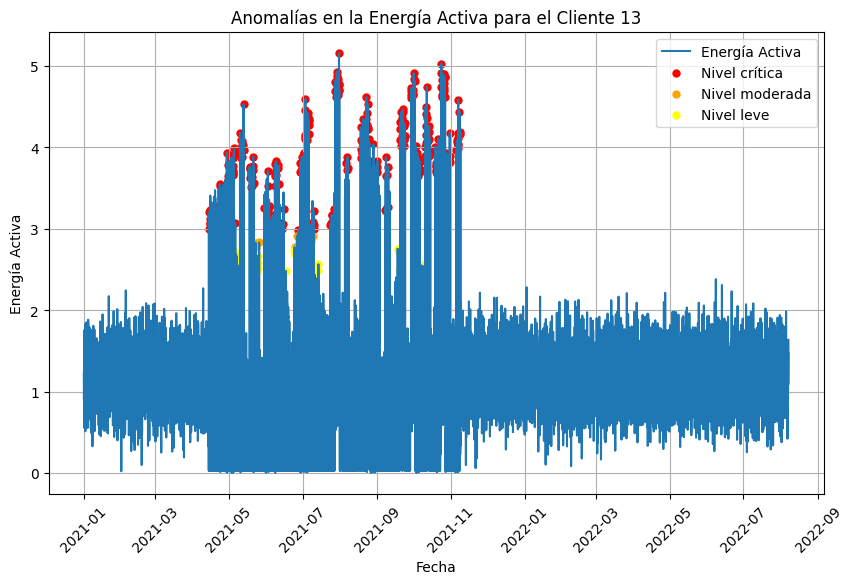

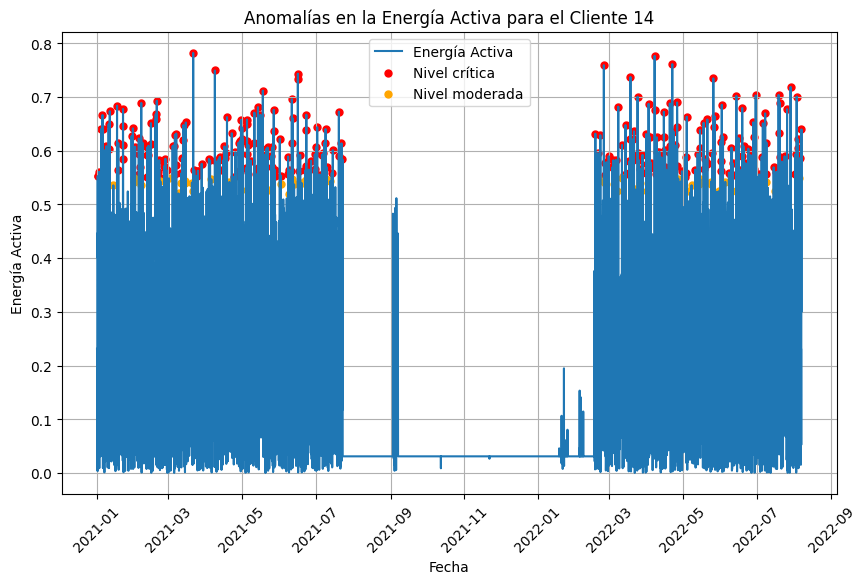

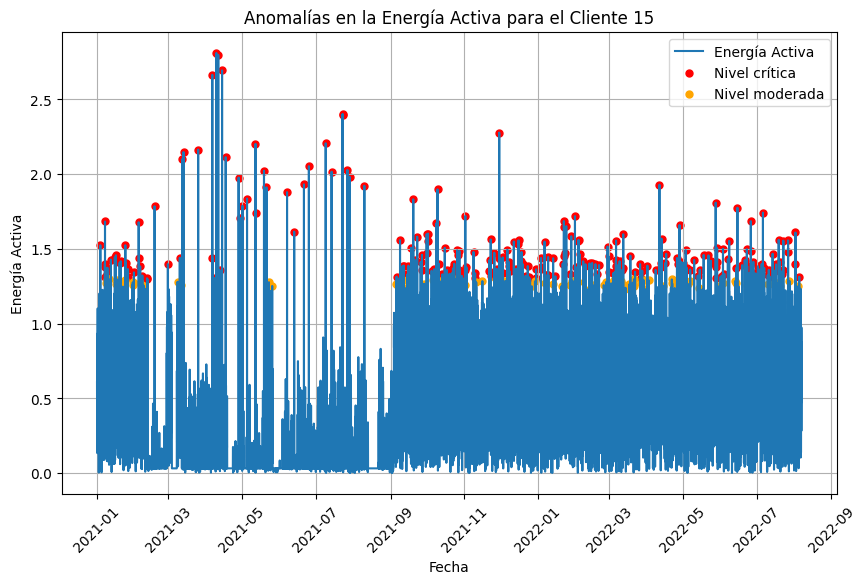

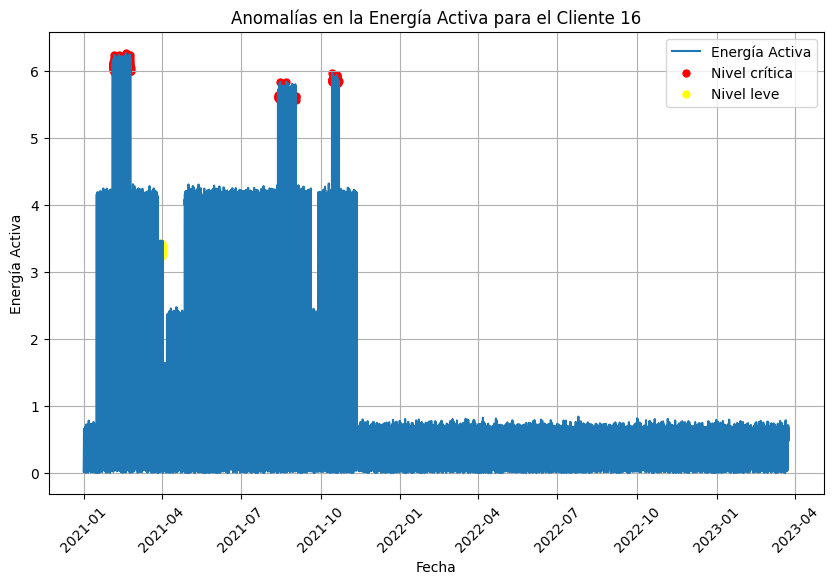

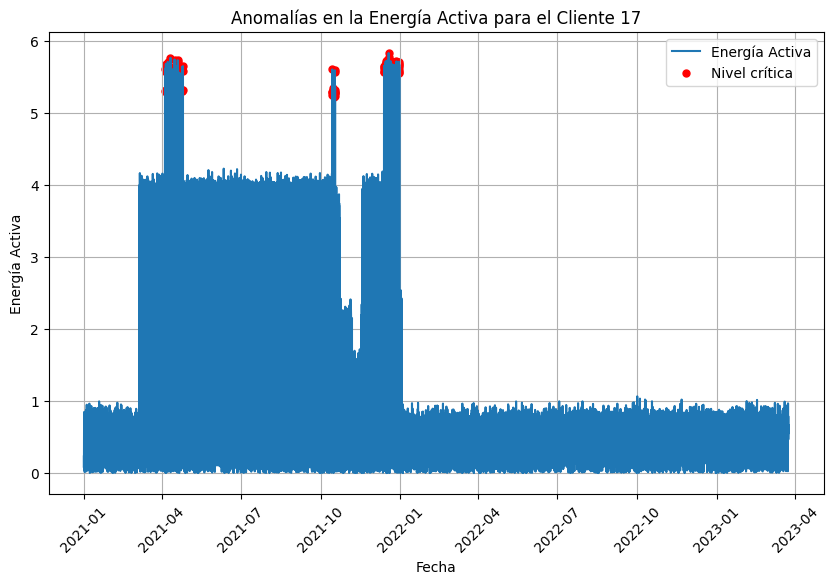

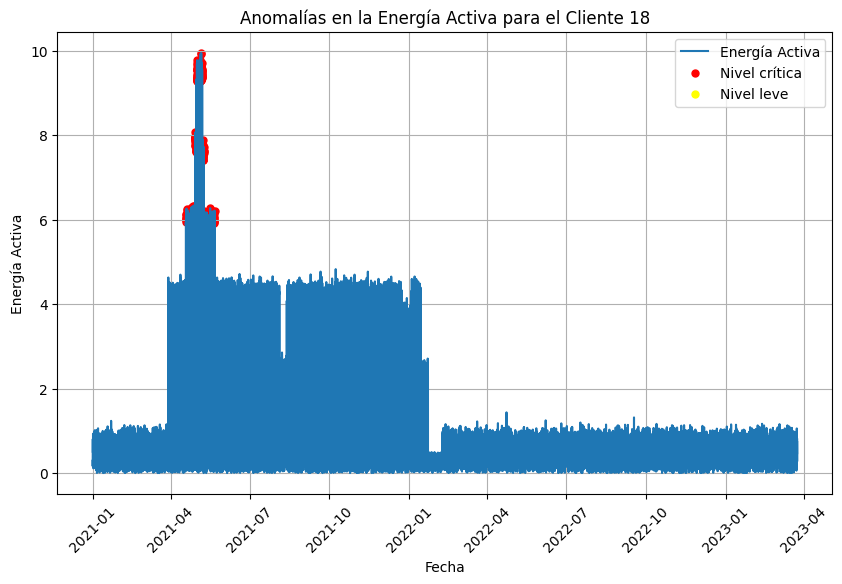

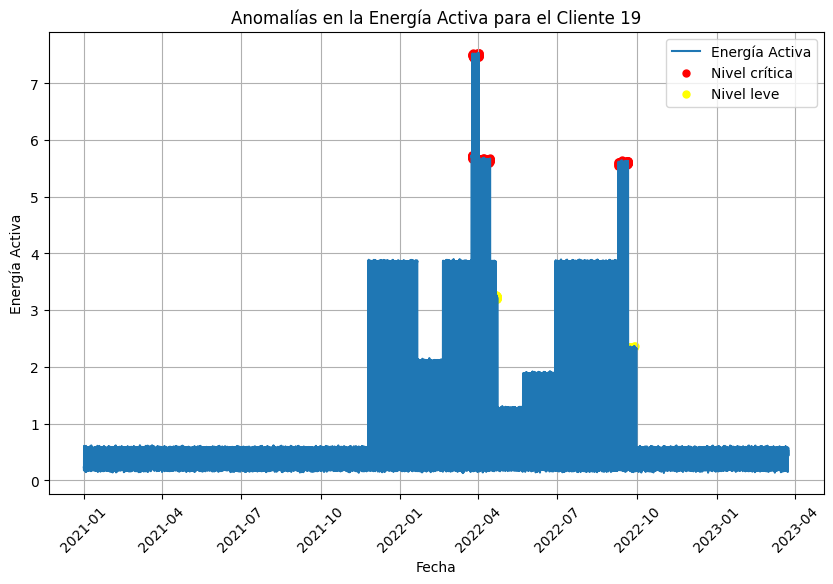

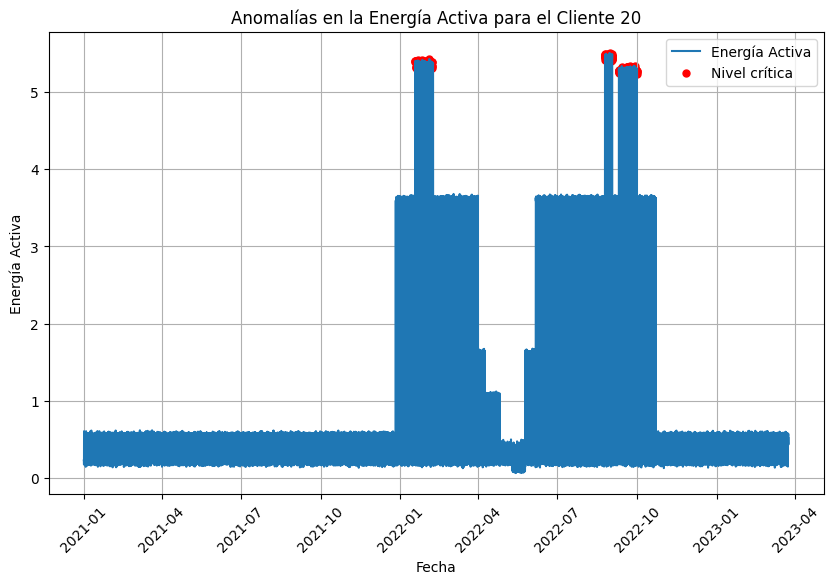

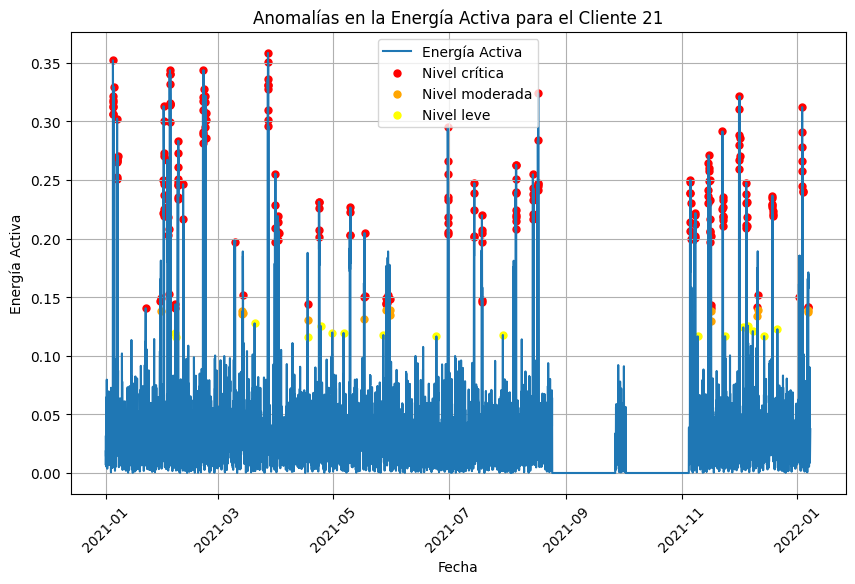

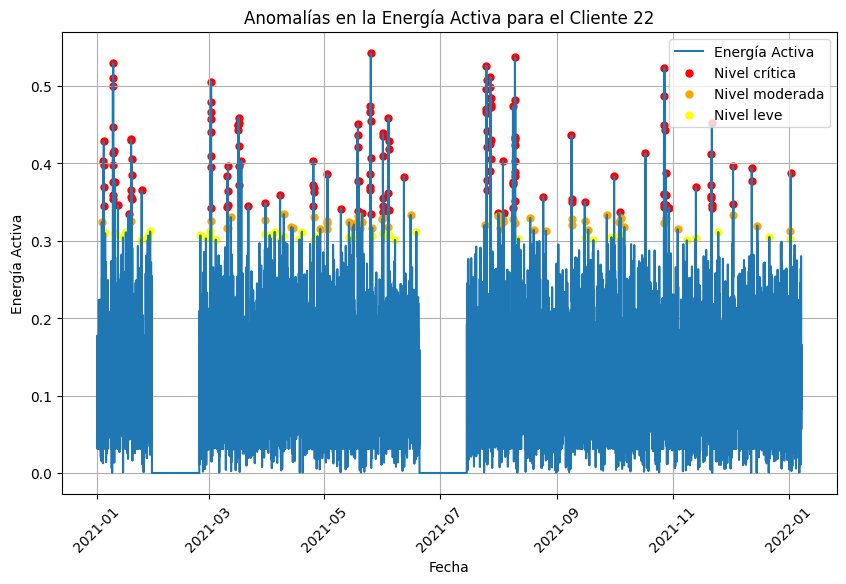

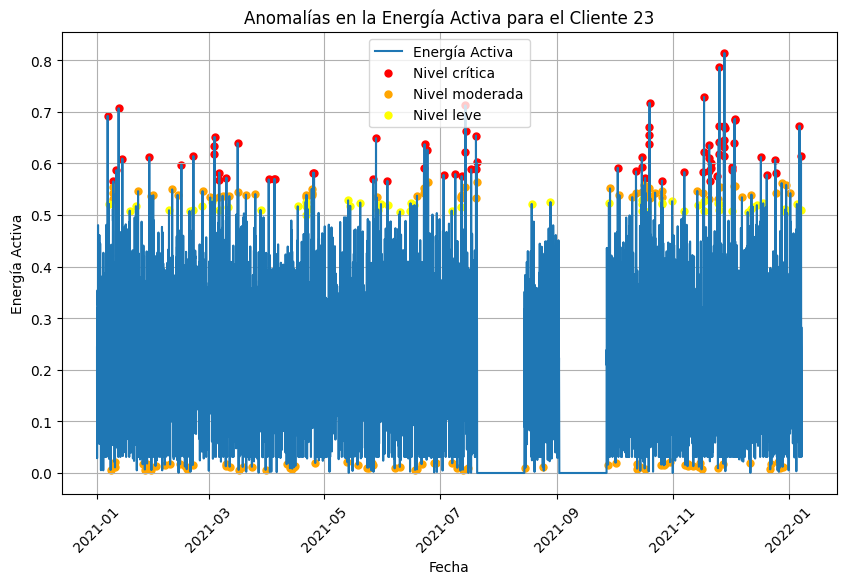

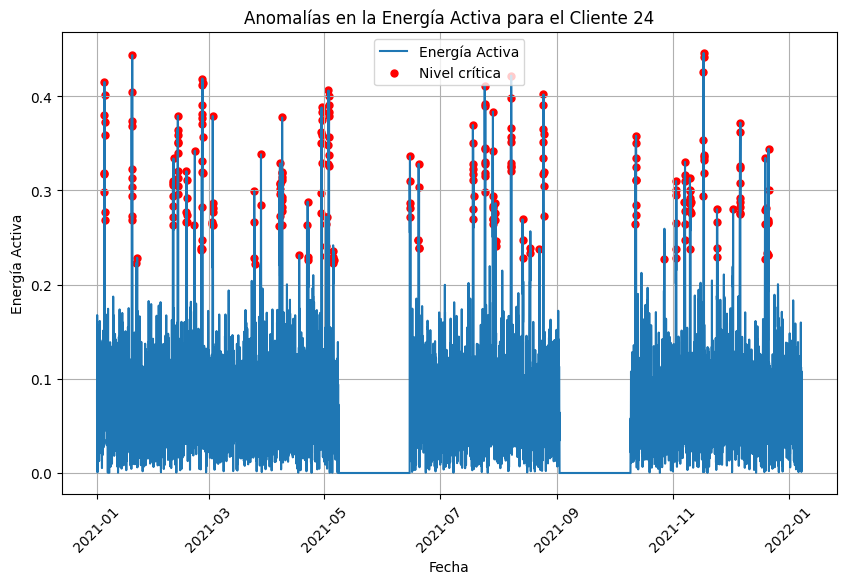

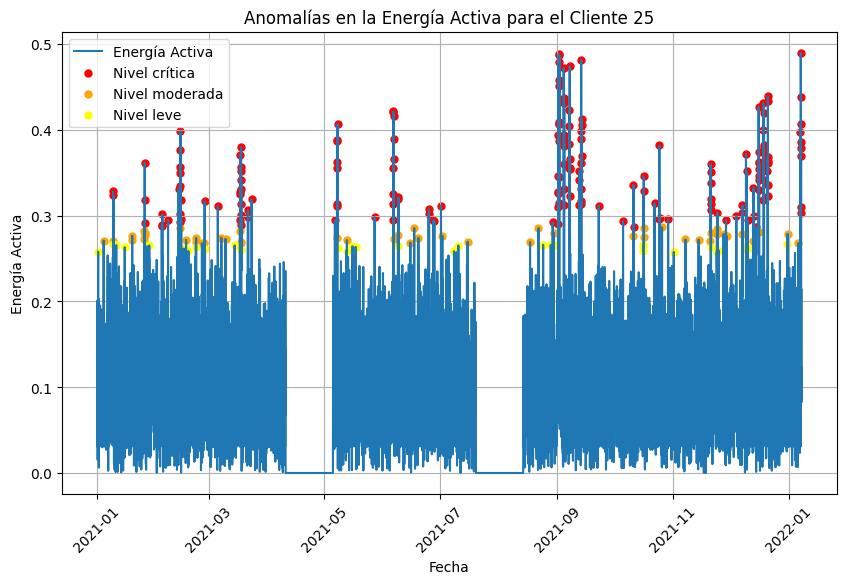

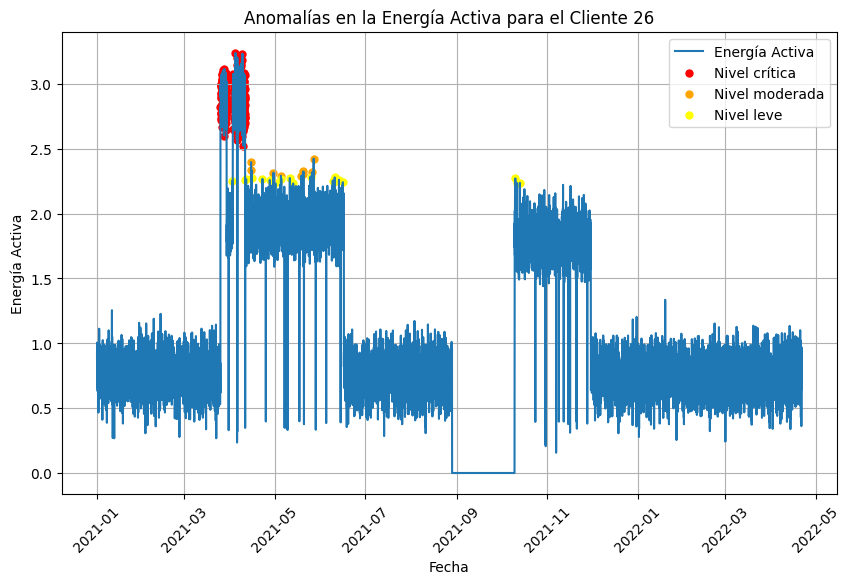

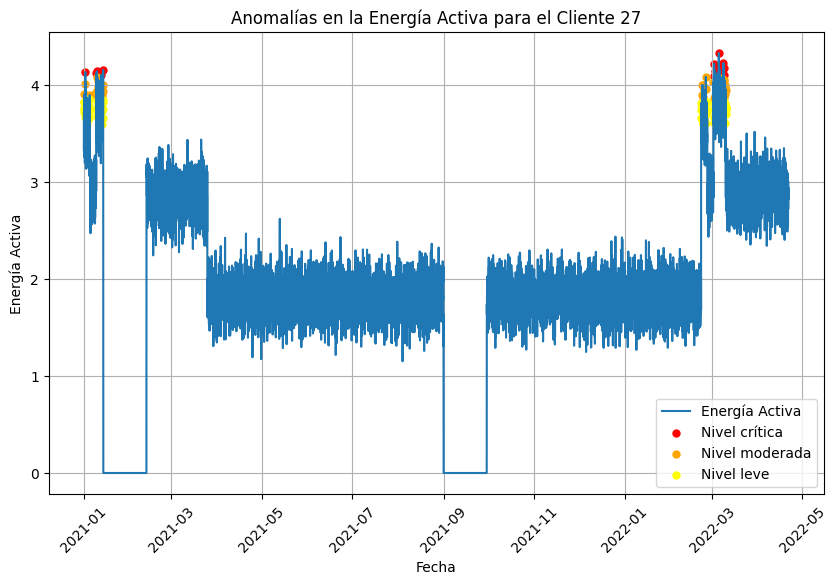

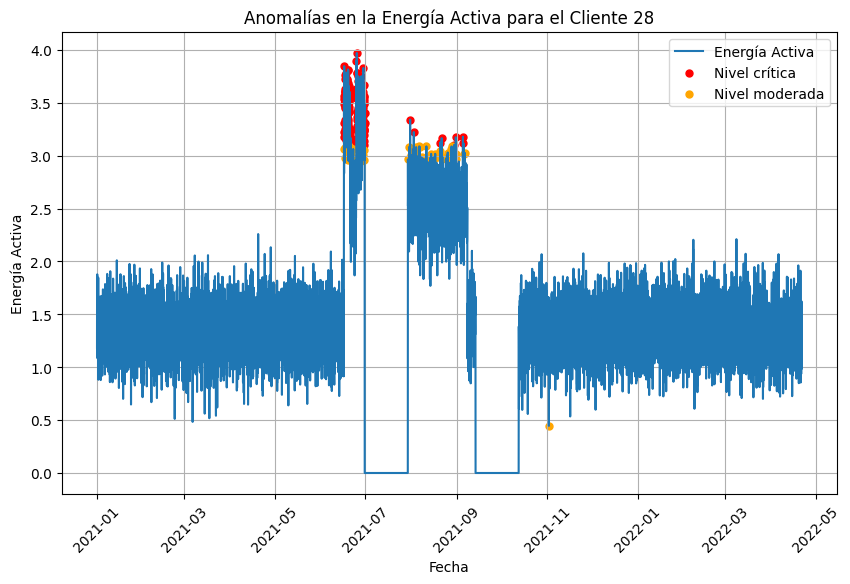

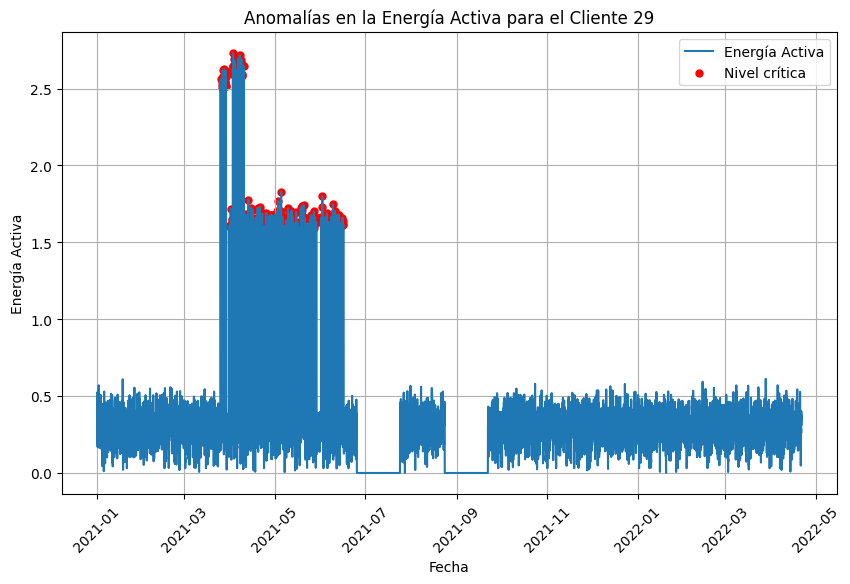

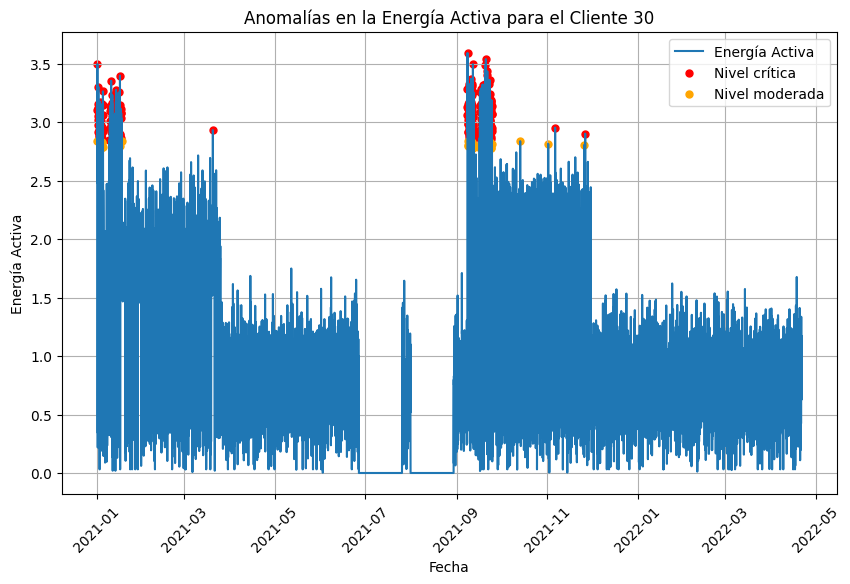

In [ ]:
graficar_energia_por_cliente_y_anomalia(df_anomalias_IF)